### Example 1 — Walk‑Forward Long only Tail‑Threshold Strategy on SPY (Daily)

This example downloads unadjusted daily OHLCV data for SPY, builds a 3‑feature volatility‑scaled predictor matrix, and runs a walk‑forward   
back‑test that ,re‑fits an OLS model every  month (21 days), using all past data.   
The model forecasts next‑day ATR‑scaled log price change;   
Trades are only placed when predictions fall in extreme percentiles,    
chosen as to maximise training Sharpe ratio subject to a minimum trade count constraint. Net log returns include a 0.1 bp transaction cost.  

In [15]:
from wft import  fetch_yf_data, WalkForward, assess_performance
from wft.plot_variables import  Visualization as vis 
import pandas as pd
import numpy as np

In [16]:
# %%
def compute_atr(high: pd.Series, low: pd.Series, close: pd.Series, period: int = 14) -> pd.Series:
    # Calculate the True Range (TR)
    high_low = high - low
    high_close_prev = (high - close.shift()).abs()
    low_close_prev = (low - close.shift()).abs()

    tr = pd.concat([high_low, high_close_prev, low_close_prev], axis=1).max(axis=1)

    # Calculate the ATR
    atr = tr.ewm(span=period, min_periods=1, adjust=False).mean() 
    return atr

def compute_variables(ohlc: pd.DataFrame, lookahead:int = 1) -> pd.DataFrame:
    # data is already in log form
    open   = ohlc['Open']
    close  = ohlc['Close']
    low    = ohlc['Low']
    high   = ohlc['High']
    volume = ohlc['Volume']

    weekly_atr = compute_atr(high , low , close , 5)
    monthly_atr = compute_atr(high , low , close , 21)

    upper  = high - np.maximum(close , open)
    lower   = np.minimum(close , open)  - low
    asymmetry = upper - lower
    ## Independent Variable 1 Assymetry between upper and lower wicks
    Intraday_asymmetry_standardized = asymmetry/ ( asymmetry.ewm(span = 20, adjust= False).std())

    ## Independent Variable 2 Volume Surprise
    vol_mean20 = volume.ewm(span = 20, adjust= False).mean()
    vol_surprise = volume  / vol_mean20 -1
    vol_surprise/=vol_surprise.ewm(span = 20, adjust= False).std()

    ## Independent Variable 3 five day return standardized by ATR(window = monthly)
    return5_over_atr = close.diff(5)/monthly_atr 

    df = pd.DataFrame(index = ohlc.index)

    df['return5_over_atr'] = return5_over_atr
    df['Intraday_asymmetry_standardized']   = Intraday_asymmetry_standardized
    df['vol_surprise']   = vol_surprise

    ## Target variable, return standardized by the weekly atr, 
    ## Standardization by the ATR computed at time T greatly reduces variance heteroskedasticity
    target =  close.diff(lookahead).shift(-lookahead)/weekly_atr 
    df.iloc[:20] = np.nan
    target.iloc[:20] = np.nan
    return df, target

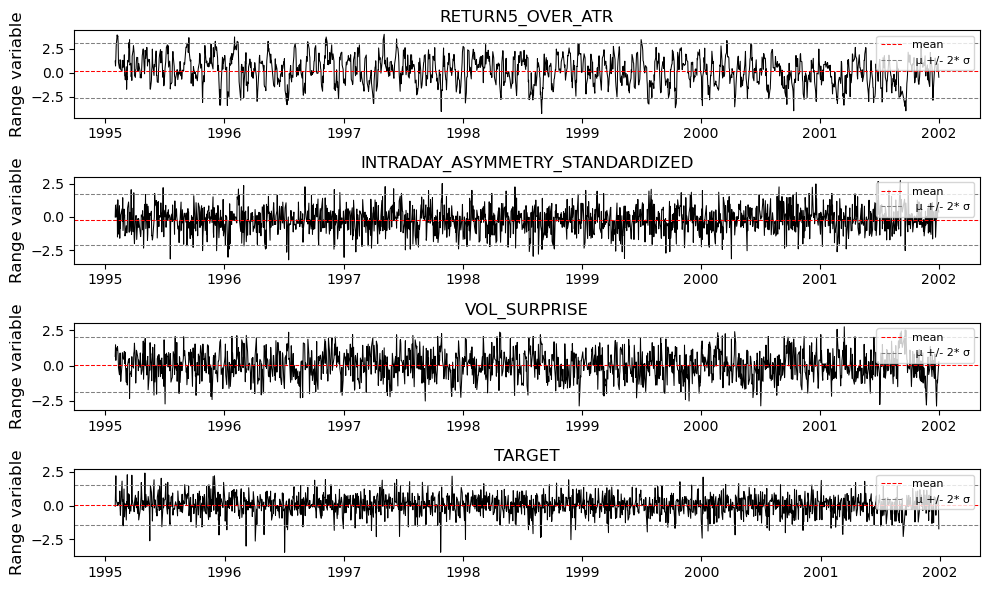

In [17]:
data = fetch_yf_data('SPY', start_date='1995-01-01', end_date='2002-01-01', auto_adjust=False)  ## Download data, built in function, see file Data.py
df,target = compute_variables(data)  # Function defined above
vars_df = df.copy()  
vars_df['target'] = target
vis.plot_time_series(vars_df)  ##  Potting time series of the variables

All variables look stationary, with a constant mean approximately zero and stable variance. There are no evident signs of heteroskedasticity, trends, or seasonality. The standardized features appear suitable for a predictive model.

2 2


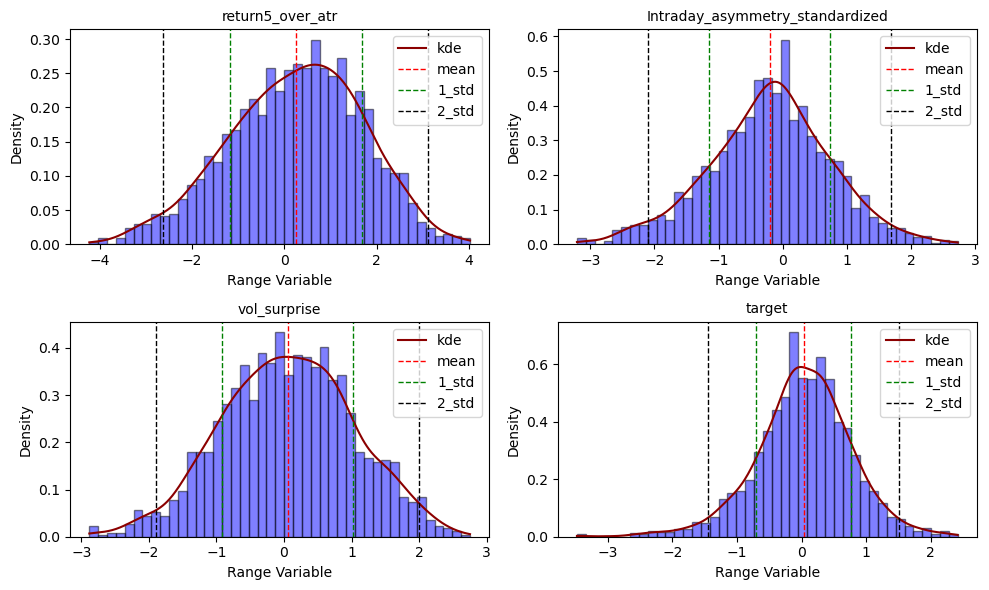

In [18]:
vis.plot_histogram(vars_df.dropna())  ## plotting a histogram of the variables

Comment on the Histograms:

All the variables have a roughly bell-shaped distribution. The target and the 5-day standardized return show a long left tail, which is typical for financial returns, but the tails are less pronounced due to standardization. There are no extreme outliers, and the distributions appear suitable for linear modeling.


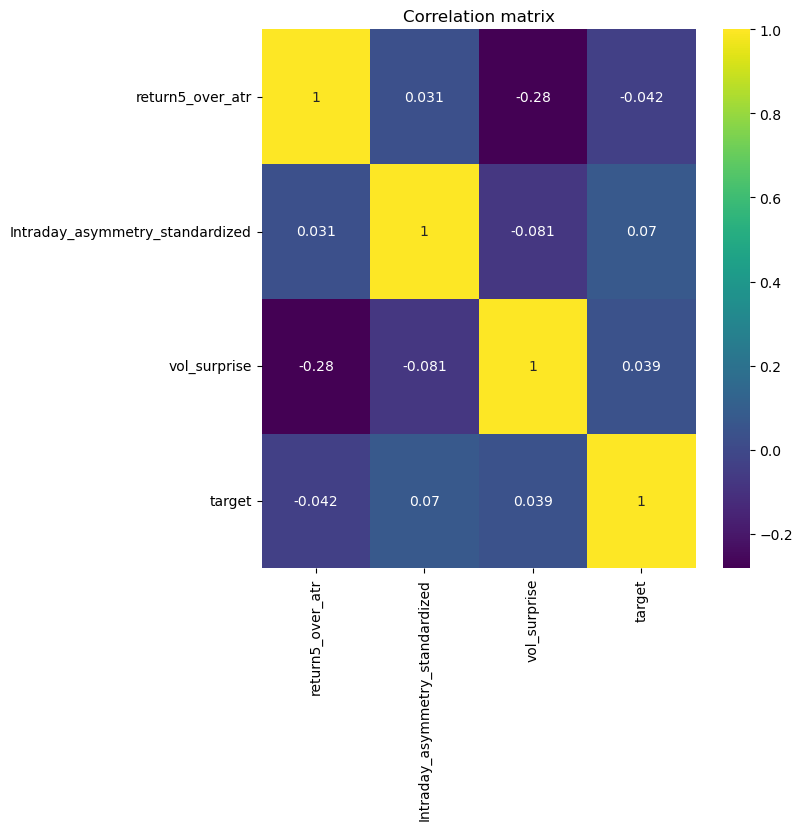

In [19]:
vis.plot_correlation(vars_df)

The correlation matrix shows that the independent variables are not strongly correlated with each other, indicating no multicollinearity. The correlations with the target are modest, which is typical for financial data, but suggest some predictive potential.

Example 1: walk‑forward back‑test on SPY daily data.

Steps
-----
1. Download unadjusted OHLCV data from Yahoo starting from year 1995 .
2. Build 3‑feature volatility‑scaled DataFrame (ret5/ATR21, Intraday_assymmetry, volume_surprise).
3. Plot Variables and asses validity for a predictive model
4. Run on all past data starting at year 5, with 3-months‑step, expanding train-size, walk‑forward engine with  1 bps commision.
5. Plot cumulative net log return vs. Buy‑and‑Hold, and various evaluation metrics.

Expected runtime: < 5 s on a laptop.

Note that all the models proposed here, and in subsequent sections, are just examples to demonstrate the framework capabilities and should not be taken as Financial advice

The next section runs the walk-forward backtest using the prepared features and target. 
It initializes the model parameters, executes the walk-forward engine, and outputs performance statistics and plots for evaluation. 
All results are based on out-of-sample predictions and the training set is purged to avoid lookahead bias.  
A commision of 1 basis point is deducted every time a position is either opened or closed.

Model Used for predictions: OLS

Methodology_action => base trade decision in the out of sample dataset, on the prediction threshold that maximizes in-sample sharpe ratio

p-value under H0: mean_return <=0 = 0.38 %
Mean Return: 0.095 %
Lower Confidence Interval: 0.04%
Upper Confidence Interval: 0.15%


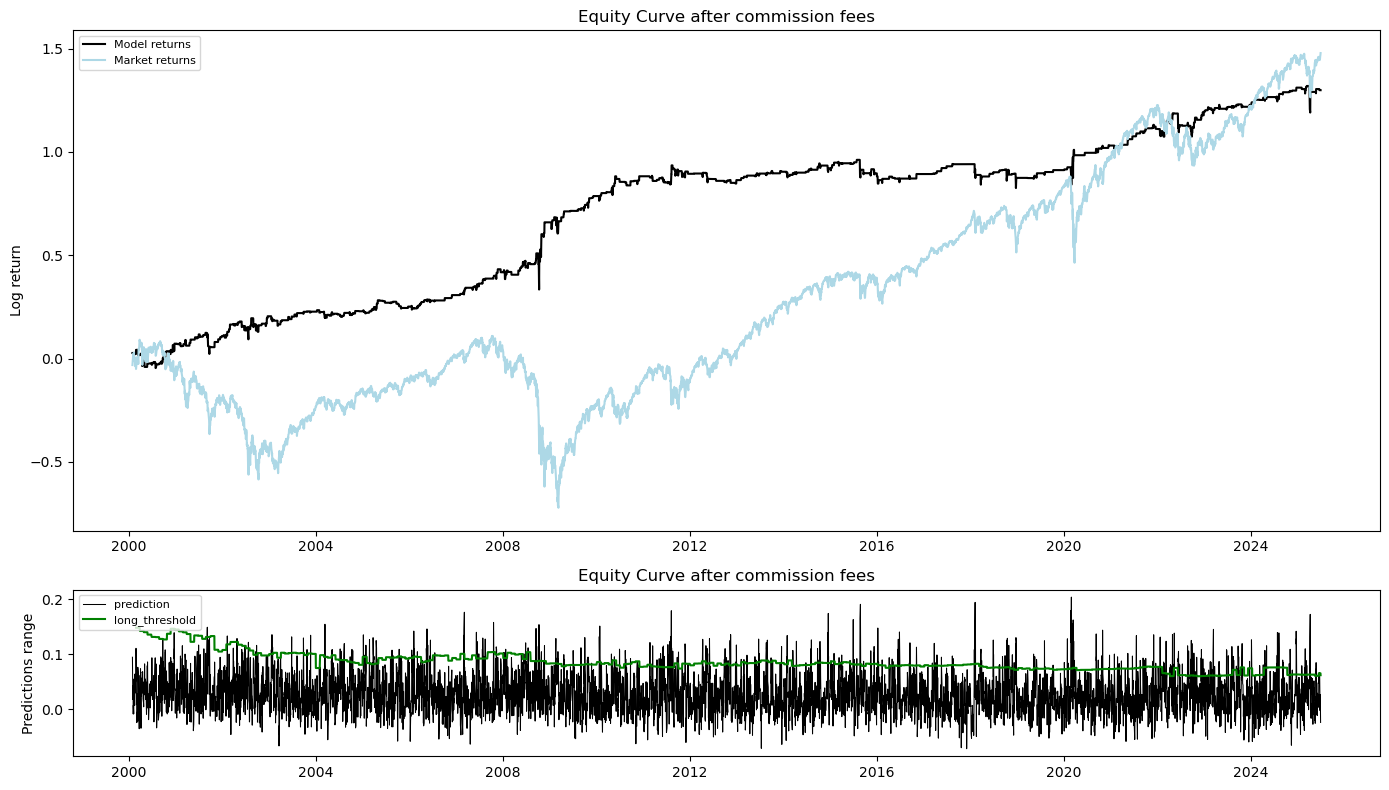

Model Decision Extrapolation:
                                 mu_long_over_t  std_long  mu_long/std_long  \
return5_over_atr                      -1.667805  1.143092         -1.459030   
Intraday_asymmetry_standardized        0.883017  0.763202          1.156989   
vol_surprise                           0.620936  0.927311          0.669609   

                                 params_ols  
return5_over_atr                  -0.016803  
Intraday_asymmetry_standardized    0.024875  
vol_surprise                       0.002077  
                          Model
Annual Return %            4.58
Sharpe Ratio Annualized    1.15
Mean Return %              0.09
Total Return %           129.84
Max Drawdown %            17.51
Profit Factor              1.33
Sharpe Ratio benchmark     0.44
Time in the market %      21.46


In [20]:
if __name__ == '__main__':
    np.random.seed(42)
    # IMPORTANT THE PROGRAM EXCPECT THE CLOSE TO BE IN LOGARITHMIC SCALE OTHERWISE RETURNS WILL BE OFF ##
    # Data is already transformed in the fetch_yf_data function
    data = fetch_yf_data('SPY', start_date='1995-01-01', end_date='2025-07-01', auto_adjust=False)  # Download data, built in function, see file Data.py
    lookahead  = 1
    inputs,target = compute_variables(data, lookahead=lookahead)
    
    # Walk-forward configurations
    start_train= 252*5         # First training window start Index
    train_size = 0             # Use all past data up to time t
    step_size  = 21            # retrain monthly

    commission   = 0.0001        # 0.1 bp per change in position
    ohlc =data[['Open', 'High', 'Low', 'Close']].copy()  ## Ohlc data, used for computing returns 

    # Model spcifications
    model_components = ['ols']          # The model Will contain only the ols estimator
    model_kwargs ={'ols':{'add_intercept':True}}  # Include the intercept
    criterion = 'sharpe_ratio'  # Choose precentile threshold as to maximize this preidiction
    min_trades = .10       # minimum trade constraint (10%)
    side = 'long'          # Only long Trades are allowed switch to None for computing both long and short trades
    # Create WalkForward instance
    WF = WalkForward(
                    inputs = inputs,
                    targets = target,
                    ohlc = ohlc,
                    max_lookahead = lookahead,
                    model_components = model_components,
                    criterion = criterion,
                    min_trades = min_trades,
                    model_kwargs = model_kwargs,
                    side = side,
                        )

    # Perform WalkForward

    net_log_ret, long_stats, short_stats = WF.run(start_train= start_train,
                                           train_size = train_size,
                                           step_size=step_size, commission=commission)
    
    mean_ret = np.round(100*net_log_ret[net_log_ret!=0].mean(),3)
    p_value, ci = assess_performance.p_value_returns(net_log_ret.values)
    print(f'p-value under H0: mean_return <=0 = {(100*p_value):.2f} %')
    print(f'Mean Return: {mean_ret} %')
    print(f'Lower Confidence Interval: {(ci[0]):.2f}%')
    print(f'Upper Confidence Interval: {(ci[1]):.2f}%')  
    
    bench_mark_returns = ohlc['Close'].diff().dropna()
    vis.plot_single_equity_curve(net_log_ret,WF.model, WF.inputs  ,long_stats,short_stats, bench_mark_returns=bench_mark_returns) 
    threshold_dict = {'long': long_stats, 'short': short_stats}
    print("Model Decision Extrapolation:")
    print(assess_performance.extrapolate_decision_model(WF.inputs ,WF.model , threshold_dict))
    df_performance = assess_performance.performance_table(net_log_ret, 'Model', bench_mark_returns, start=start_train).T 
    print(df_performance)


Comment:

In the plot above, the cumulative net log return of the walk-forward model versus Buy-and-Hold, are shown.    
The model demonstrates periods of outperformance, especially during certain market regimes, 
but also experiences flat or slightly negative stretches, reflecting the challenges of consistent alpha generation.  

The printed statistics indicate a mean return of 0.094% per trade, with a p-value (H0 : mean_returns<=0) of 0.38%, suggesting statistical significance.    
The confidence interval for the mean return does not include zero,supporting the model's effectiveness.    
 
The table of the model coefficients suggest that large positive predictions are supported on average by a large negative return from time t-1 to t (below -1.3 standard deviation), while the variable Intraday assymetry reppresenting sides imbalances is the most relevant with largest ols coefficient, volume seems not to be too important. The performance table reports various metrics model assesments. Overall, the results suggest the model is robust.

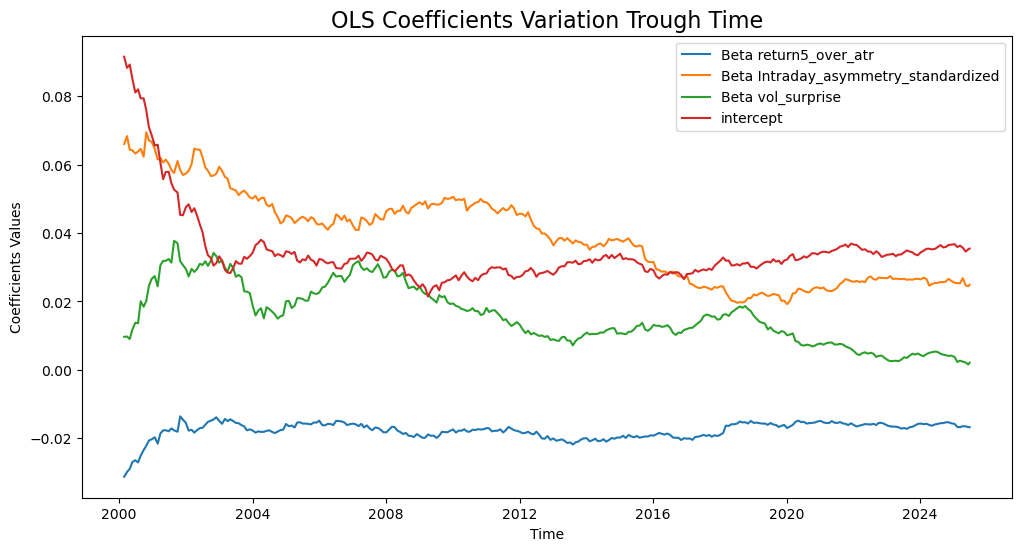

In [21]:
import matplotlib.pyplot as plt
n_coefs = WF.inputs.shape[1]
df = pd.DataFrame(columns=[f"Beta {name}" for name in inputs.columns], index = long_stats["Start_test"])
df["intercept"] = [np.nan]*len(df)
df.loc[long_stats["Start_test"]] = [long_stats["params"][i].get("ols").get("coefficients") for i in range(len(long_stats))]
plt.figure(figsize = (12,6))
for name, values in df.items():
    plt.plot(df.index,  values, label = name)
plt.ylabel("Coefficients Values")
plt.xlabel("Time")
plt.title("OLS Coefficients Variation Trough Time", fontsize = 16)
plt.legend()
plt.show()


Comment on OLS coefficients

From the plot of the evolution of the OLS coefficients trough time, 
we can determine that the beta of the standardized 5 day returns, is the most stable, 
while other betas seems to vary more over the period taken under scrutiny,     
indicating that the relationship between the target variable (next day standardized return),    
and the volume and high/low based variables is not consistent trough time, it's changing.
Making them less attractive as predictor candidates


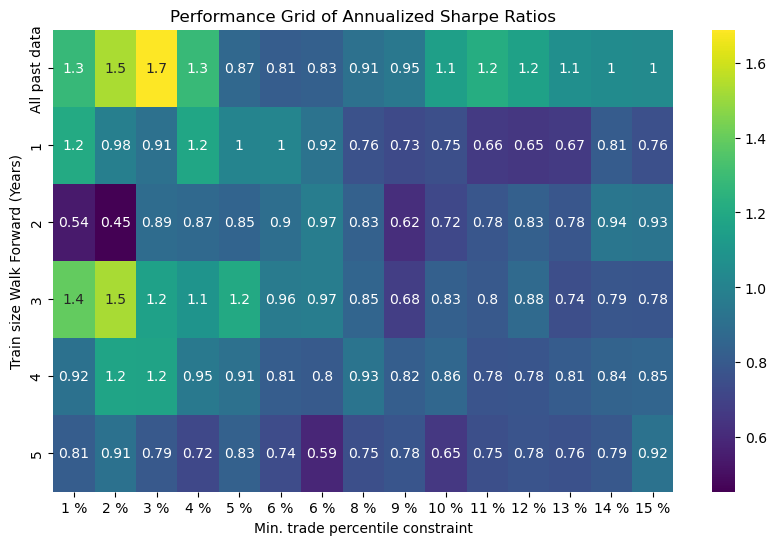

Maximum: 1.688, Train size in Years: All past data, Minimum trades Constrain: 3 %
Minimum: 0.455, Train size in Years: 2, Minimum trades Constrain: 2 %
Mean Performance across all hyperparameters: 0.904


In [22]:
def compute_performance(train_size, min_trades_pct, data, inputs, target):   

    start_train= 252*5            
    step_size  = 21             
    commission  = 0.0001       
    ohlc =data[['Open', 'High', 'Low', 'Close']].copy()   
    max_lookahead = 1           
    model_components = ['ols']  
    model_kwargs ={'ols':{'add_intercept':True}}  
    criterion = 'sharpe_ratio'

    side = 'long'    
    WF = WalkForward(
                    inputs = inputs,
                    targets = target,
                    ohlc = ohlc,
                    max_lookahead = max_lookahead,
                    model_components = model_components,
                    criterion = criterion,
                    min_trades = min_trades_pct,
                    model_kwargs = model_kwargs,
                    side = side,
                        )

    # Perform WalkForward

    net_log_ret, *_ = WF.run(start_train= start_train,
                                           train_size = train_size,
                                           step_size=step_size, commission=commission)
    mean_return = net_log_ret[net_log_ret!=0].mean()
    std_returns = net_log_ret[net_log_ret!=0].std()
    sharpe = mean_return/(std_returns )
    return sharpe*(252**.5)


train_size_options = np.arange(0,252*5 +1, 252) # 5 years max so that start_train >= train_size
min_trades_options =  np.arange(0.01, 0.15 + 0.01, 0.01) # no point going above the 50th percentile  
data = fetch_yf_data('SPY', start_date='1995-01-01', end_date='2025-07-01', auto_adjust=False)   
lookahead  = 1 
inputs,target = compute_variables(data, lookahead=lookahead)
performance_grid = np.zeros((train_size_options.size, min_trades_options.size))

# Caluclate performance for each param
for i,train_size in enumerate(train_size_options):
    for k,min_trades_pct in enumerate(min_trades_options):
        performance_grid[i,k] = compute_performance(train_size=train_size, 
                                                    min_trades_pct=float(min_trades_pct),
                                                    data=data, inputs=inputs, target=target)
        
# Plot params performance
import seaborn as sns
import matplotlib.pyplot as plt
columns_df = [f"{int(val*100)} %" for val in min_trades_options]
index_df =  [f"{val//252}" for val in train_size_options]
index_df[0] = 'All past data'
performance_grid_df = pd.DataFrame(performance_grid, columns = columns_df,index = index_df)

series_grid = performance_grid_df.stack()
row_name_max, col_name_max = series_grid.idxmax()
max_value = series_grid.max()

row_name_min, col_name_min = series_grid.idxmin()
min_value = series_grid.min()

mean_value = np.mean(performance_grid_df)

plt.figure(figsize=(10,6))
plt.title('Performance Grid of Annualized Sharpe Ratios')
sns.heatmap(performance_grid_df, cmap = 'viridis', annot= True)
plt.xlabel("Min. trade percentile constraint")
plt.ylabel("Train size Walk Forward (Years)")
plt.show()

print(f"Maximum: {round(max_value,3)}, Train size in Years: {row_name_max}, Minimum trades Constrain: {col_name_max}")
print(f"Minimum: {round(min_value,3)}, Train size in Years: {row_name_min}, Minimum trades Constrain: {col_name_min}")
print(f"Mean Performance across all hyperparameters: {round(mean_value,3)}")

Comment on Hyperparametrs sensitivity:

In my opinion the 2 most import hyperparameters used in the walk forward are:   
-   The number of observation included in the fitting window of the WalkForward
-   The trades constraint, the minimum number of trades     

The plot above illustrate how the performance changes as we tweak theese 2 hyperparameters,     
the performance remains positve across all combinations tested, the most optimal sweetspot  
is found using all past data, up to time of train, to fit model and use a small minimum trades constraint.      

Note that using a small trades constraint as founds here, may decrease the validity of the model,   
as few lucky large trades may mislead the performance.

In [23]:
import sys
print(f'version python: {sys.version}')
print(f'version Numpy: {np.version.version}')
print(f'version Pandas: {pd.__version__}')


version python: 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
version Numpy: 1.26.4
version Pandas: 2.1.4
